In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.special import softmax
import random
import pickle
from datetime import datetime
from collections import Counter

from tqdm import tqdm

import gym
from gym.spaces import Discrete, Tuple

from env_mp_simple import MetaGamesTheOne
from rmax_1_batch_TheOne import RmaxAgent, Memory

def discretize(number, radius):
    #[0,3,5,4,8] --> [0,3,6,3,9] for radius 3
    return np.round(np.divide(number, radius)) * radius

def Boltzmann(arr):
    #0.5 is just a temperature parameter, controls the spread of the softmax distribution
    action_value = np.zeros(arr.shape[0])
    prob = softmax(arr/0.4, 1)
    for b in range(arr.shape[0]):
        action_value[b] = np.random.choice(np.arange(arr.shape[1]), p=prob[b])
    return action_value

bs = 1
inner_gamma = 0         #inner game discount factor, 0 since it's a one shot game
meta_gamma = 0.95        #meta game discount factor

R_max = 1.5
rmax_error = 0.05
meta_epi = 18000
meta_steps = 5

epsilon = 0.8
step = 0.1

In [ ]:
#reward tensor for plotting purposes [bs, episode, step, agents]
plot_rew = np.zeros((bs, meta_epi, meta_steps, 2))

# creating environment
env = MetaGamesTheOne(bs, step, meta_steps)

# creating rmax agent
memory = Memory()
rmax = RmaxAgent(R_max, bs, meta_gamma, inner_gamma, step, epsilon, rmax_error)

In [ ]:
for episode in tqdm(range(meta_epi)): #for each meta-episode
    print("round " + str(episode))
    #reset environment 
    #initialise meta-state and meta-action randomly
    meta_s = env.reset()
   
    for step in range(meta_steps):    #for each meta time step
        print("attempt " + str(step))
        #--------------------------------------START OF INNER GAME--------------------------------------  
        #select our inner-action with Boltzmann sampling, oppo inner-action with epsilon greedy 
        our_action = np.zeros((bs), dtype=int)
        for i in range(bs):
            if env.done[i,0] == 0:    #if we didn't jump 
                our_action[i] = Boltzmann(rmax.Q[[i], rmax.find_meta_index(meta_s, "s").astype(int)[i], :])
            else:
                our_action[i] = 1
        
        #print("inner actions: ", our_action, oppo_action)
        #run inner game according to actions
        obs, reward, info, _ = env.step(our_action) 
        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[:,episode,step,0] = reward
        plot_rew[:,episode,step,1] = info

        #meta-action = action that corresponds to max Q(meta_s) = our inner Q
        meta_a = our_action

        #meta-state = discretized inner game Q table of all agents
        new_meta_s = obs

        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward    
        memory.rewards.append(our_REW)

        #rmax update step
        rmax.update(memory, meta_s, meta_a, new_meta_s)
        
        for b in range(rmax.bs):       #NEED THIS SO OUR Q WONT OVERFLOW
            if (all(env.done[b]) == True) and reward <= 0.8:
                rmax.R[b, rmax.find_meta_index(meta_s, "s").astype(int), rmax.find_meta_index(meta_a, "a").astype(int)] = 0
                
        #prepare meta_s for next step
        meta_s = new_meta_s


In [ ]:
# # Open a file and use dump()
# with open('plot_rew' + str(datetime.now()) + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(plot_rew, file)

# # Open a file and use dump()
# with open('rmax_nSA' + str(datetime.now()) + '.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(rmax.nSA, file)

# Plots

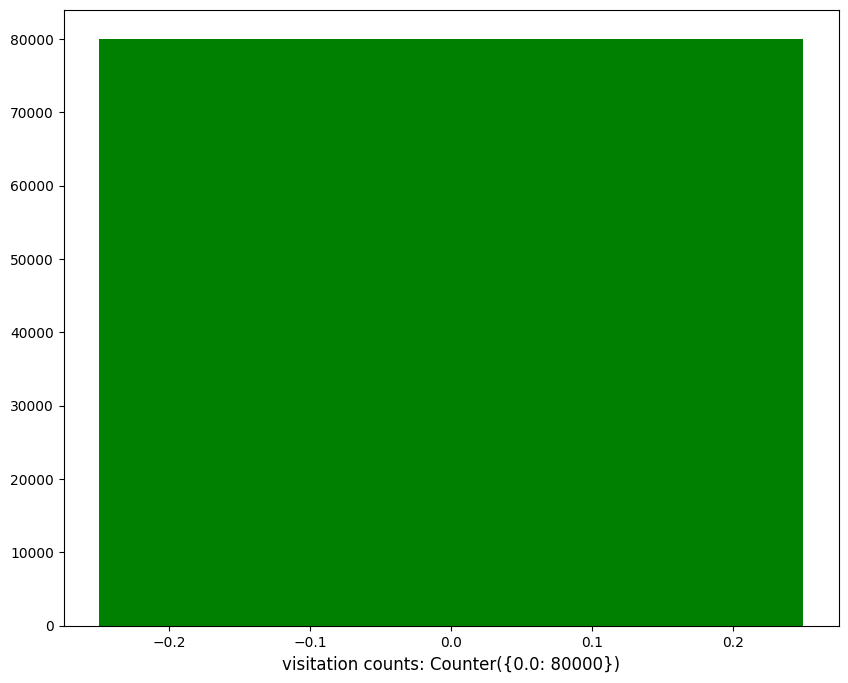

In [5]:
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA[0].flatten().tolist())):
    visit_dict[i]= rmax.nSA[0].flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.xlabel("visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
plt.savefig('histogram at' + str(datetime.now()) + '.png')

In [ ]:
#generate heatmap
plt.imshow(rmax.nSA[0], cmap='hot', interpolation='nearest')
figure1 = plt.gcf()
figure1.set_size_inches(50, 200)
plt.savefig('heatmap for' + str(datetime.now()) + '.png')

In [ ]:
#generate MA(5) reward  of batch 0 
a = plot_rew[0,:,-1,0]
b = np.convolve(a, np.ones(300)/300, mode='valid')
fig_handle = plt.plot(b)
#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew[0,:,-1,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew[0,:,-1,1]))+
          "\n meta-episode= "+ str(meta_epi) + " meta_steps= " + str(meta_steps) + " meta_gamma= " + str(meta_gamma) + " step= " + str(step)+
          "\n % of visited states= " + str((rmax.nSA >= rmax.m).sum() / (rmax.nSA.shape[1] * rmax.nSA.shape[2])))

plt.ylabel("Mean rewards")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)
plt.savefig('MAReward for' + str(datetime.now()) + '.png')

# Interpreting results 

In [4]:
# import glob

# path1 = "plot_rew*.pkl"
# path2 = "rmax*.pkl"
        
# for filename in glob.glob(path1):    
#     with open(filename, 'rb') as g:
#         plot_rew = pickle.load(g)
        
# for filename in glob.glob(path2):    
#     with open(filename, 'rb') as g:
#         rmax = pickle.load(g)        